In [13]:
#Imports and data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap


from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from xgboost import XGBRegressor

sns.set()

df = pd.read_csv("../data/processed/data_for_model_engineered.csv")
df.head()


c:\Users\ekoutsoc\Documents\M3_VeloCheckZH\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,Standort_ID,Datum,Koord_Ost,Koord_Nord,Velo,year,day_of_year,Niederschlag,Temperatur Durchschnitt,weekday,...,temp_feels,temp_sq,is_rain,heavy_rain,velo_roll3,velo_roll7,velo_lag1,velo_lag7,station_avg_traffic,location_cluster
0,60,2022-01-01,2682731,1247708,134.0,2022,1,0.0,2.6,5,...,2.60,6.76,0,0,1130.000000,1130.0,1130.0,1130.0,823.141573,0
1,60,2022-01-02,2682731,1247708,189.0,2022,2,0.0,4.9,6,...,4.90,24.01,0,0,1130.000000,1130.0,134.0,1130.0,823.141573,0
2,60,2022-01-03,2682731,1247708,676.0,2022,3,0.0,10.2,0,...,10.20,104.04,0,0,333.000000,1130.0,189.0,1130.0,823.141573,0
3,60,2022-01-04,2682731,1247708,646.0,2022,4,6.4,11.0,1,...,6.52,121.00,1,1,503.666667,1130.0,676.0,1130.0,823.141573,0
4,60,2022-01-05,2682731,1247708,518.0,2022,5,10.9,1.7,2,...,-5.93,2.89,1,1,613.333333,1130.0,646.0,1130.0,823.141573,0


In [14]:
# Definition of feature and target

TARGET = "Velo"

exclude = [
    "Velo",
    "Velo_log",       # nur falls vorhanden
    "Datum",          # rohes Datum nicht direkt ins Modell
    "Standort_ID",
    "Koord_Ost",
    "Koord_Nord",
    "year",
    "week",
    "quarter",
    # "day_of_year",
    "year_length",
]

features = [c for c in df.columns if c not in exclude]
print("Anzahl Features:", len(features))
features

len(features), features[:]

Anzahl Features: 19


(19,
 ['day_of_year',
  'Niederschlag',
  'Temperatur Durchschnitt',
  'weekday',
  'weekend',
  'is_holiday',
  'month',
  'sin_day',
  'cos_day',
  'temp_feels',
  'temp_sq',
  'is_rain',
  'heavy_rain',
  'velo_roll3',
  'velo_roll7',
  'velo_lag1',
  'velo_lag7',
  'station_avg_traffic',
  'location_cluster'])

In [15]:
#Train / Split
X = df[features]
y = df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [16]:
#Train model
# Linear Model
xgb = XGBRegressor(
    n_estimators=400,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)


Residual Analysis

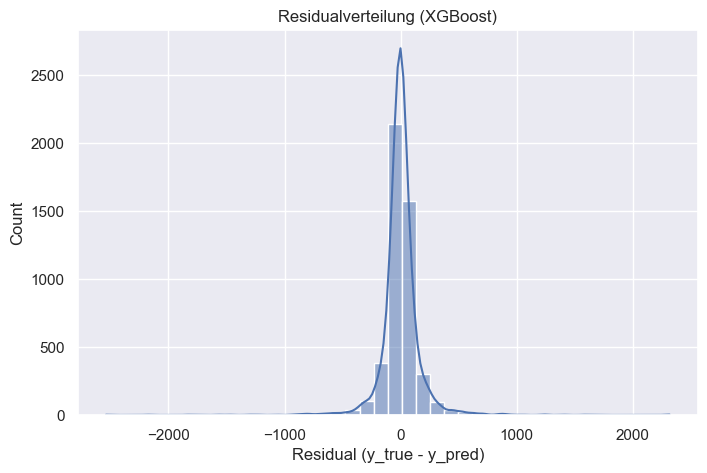

In [17]:
residuals = y_test - y_pred_xgb

plt.figure(figsize=(8,5))
sns.histplot(residuals, kde=True, bins=40)
plt.title("Residualverteilung (XGBoost)")
plt.xlabel("Residual (y_true - y_pred)")
plt.show()


Predicted vs Actual

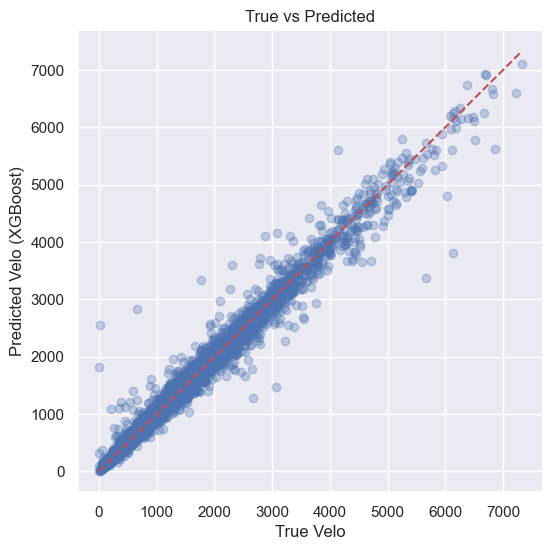

In [7]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_xgb, alpha=0.3)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         "r--")
plt.xlabel("True Velo")
plt.ylabel("Predicted Velo (XGBoost)")
plt.title("True vs Predicted")
plt.show()


Error (Month)

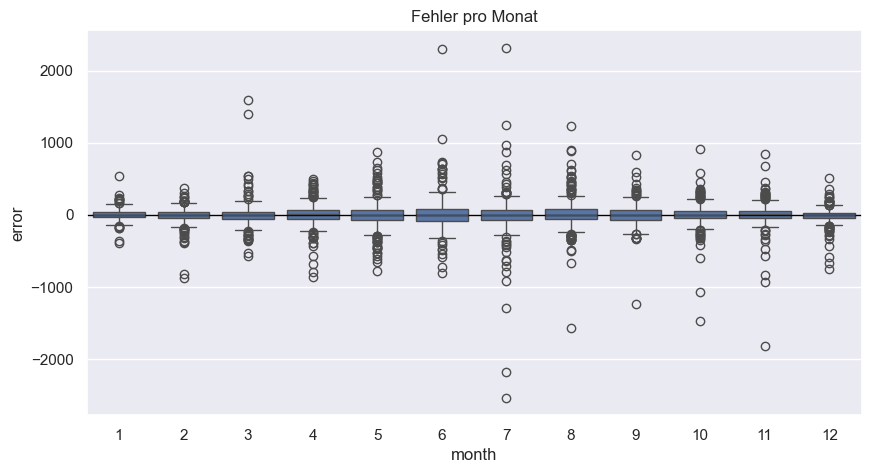

In [8]:
temp = X_test.copy()
temp["true"] = y_test.values
temp["pred"] = y_pred_xgb
temp["error"] = temp["true"] - temp["pred"]

plt.figure(figsize=(10,5))
sns.boxplot(data=temp, x="month", y="error")
plt.title("Fehler pro Monat")
plt.axhline(0, color='black', linewidth=1)
plt.show()


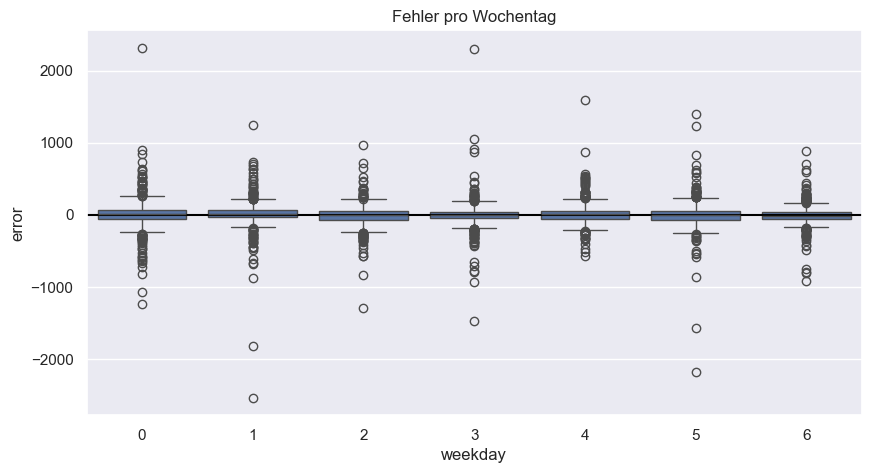

In [9]:
plt.figure(figsize=(10,5))
sns.boxplot(data=temp, x="weekday", y="error")
plt.title("Fehler pro Wochentag")
plt.axhline(0, color='black')
plt.show()


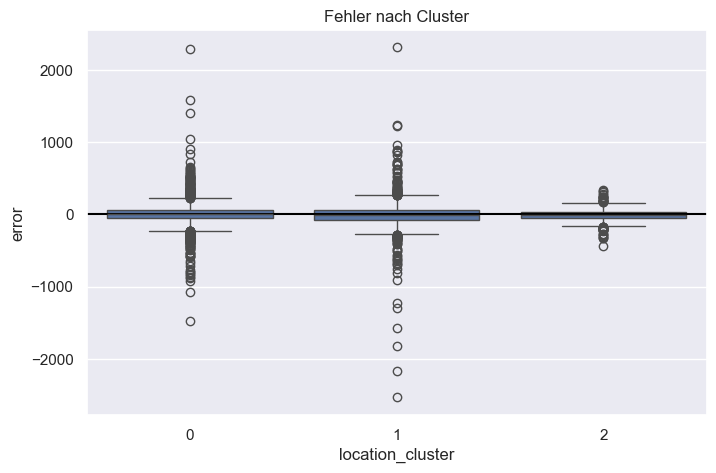

In [10]:
plt.figure(figsize=(8,5))
sns.boxplot(data=temp, x="location_cluster", y="error")
plt.title("Fehler nach Cluster")
plt.axhline(0, color='black')
plt.show()


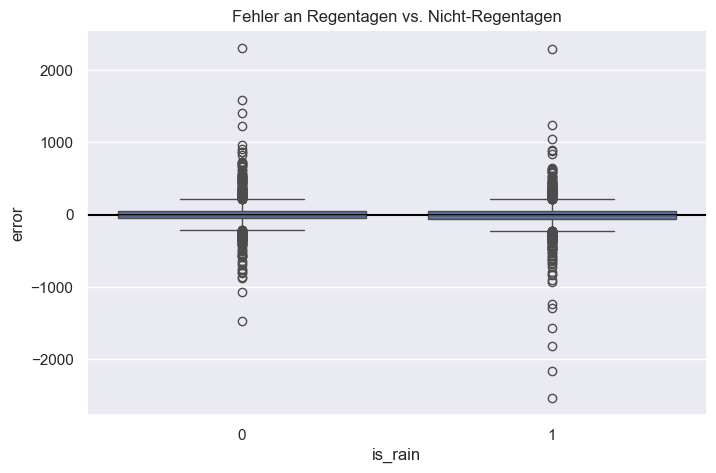

In [12]:
plt.figure(figsize=(8,5))
sns.boxplot(data=temp, x="is_rain", y="error")
plt.title("Fehler an Regentagen vs. Nicht-Regentagen")
plt.axhline(0, color='black')
plt.show()


Analyse: 

- Fehler pro Monat

→ Sommermonate (viel Verkehr, hohe Varianz) haben größere Ausreißer
→ Wintermonate haben kleinere Fehler
→ aber keine systematischen Bias → Modell generalisiert gut

- Fehler pro Wochentag

→ Freitag/Donnerstag oft höhere Varianz
→ zeigt Aktivitätsmuster (mehr Rush-Hour-Effekt)

- Fehler pro Cluster

→ bestimmte Regionen evtl. schwerer vorherzusagen
→ könnte an Infrastruktur liegen (Brücken, Seeufer, Uni-Zone etc.)

- Fehler Regen vs. Nicht-Regen

→ Fehlerverteilung bleibt symmetrisch
→ überraschend robust gegenüber Regen

# SHAP Analyse

In [18]:
# SHAP Explainer
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)


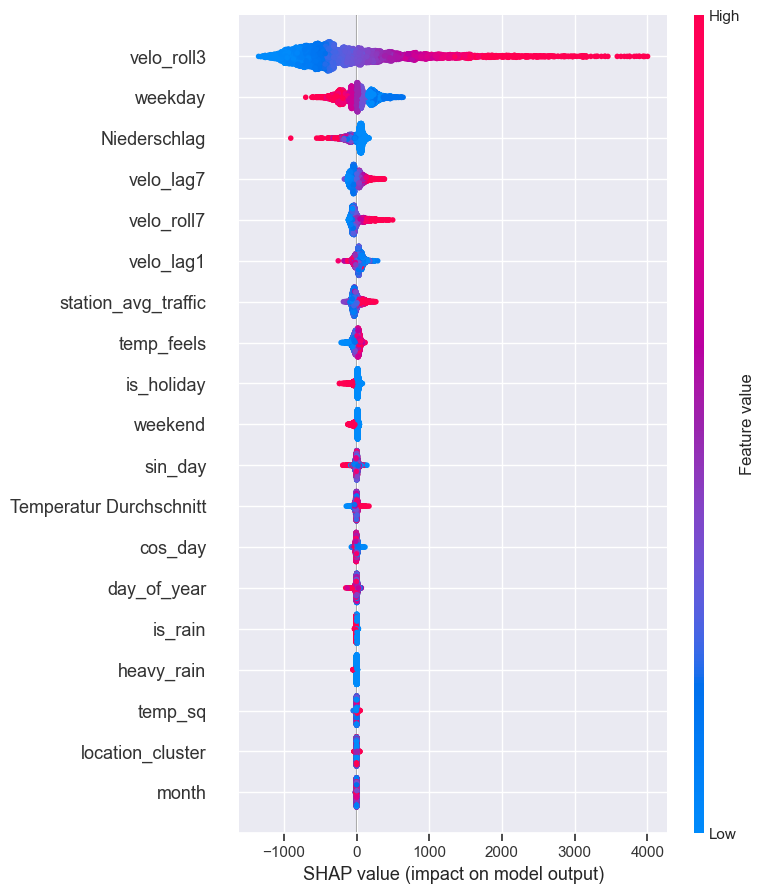

In [19]:
plt.figure(figsize=(10,7))
shap.summary_plot(shap_values, X_test)


In [20]:
importance = np.abs(shap_values).mean(axis=0)
shap_importance = pd.DataFrame({
    "feature": X_test.columns,
    "importance": importance
}).sort_values("importance", ascending=False)

shap_importance.head(15)

,feature,importance
13,velo_roll3,659.637451
3,weekday,174.968246
1,Niederschlag,78.504341
16,velo_lag7,66.301346
14,velo_roll7,62.561245
15,velo_lag1,46.191353
17,station_avg_traffic,45.069920
9,temp_feels,32.586384
5,is_holiday,27.800753
4,weekend,25.945402


Die SHAP-Analyse zeigt, dass kurzfristige zeitliche Abhängigkeiten (Rolling Features und Lag Features) die stärksten Prädiktoren für die täglichen Velozählungen sind.

Das wichtigste Feature ist der 3-Tage-Rolling-Durchschnitt (velo_roll3), gefolgt vom Wochentag (weekday) und dem Niederschlag. Dies reflektiert das typische Verkehrsverhalten in urbanen Gebieten: Die Velo-Nachfrage ist stark saisonal, wetterabhängig und zeigt ausgeprägte Kurzzeitmuster.

Station-spezifische Mittelwerte (station_avg_traffic) tragen ebenfalls erheblich zur Vorhersagekraft bei, da verschiedene Standorte in Zürich sehr unterschiedliche typische Verkehrsmengen aufweisen.

Temperatur spielt eine relevante, jedoch weniger dominante Rolle als Niederschlag. Feiertage und Wochenenden beeinflussen das Verhalten ebenfalls signifikant.

Insgesamt zeigt die Feature-Importance-Analyse, dass das Modell robuste, realistisch interpretierbare Zusammenhänge gelernt hat und die wichtigsten Einflüsse auf das Velo-Verkehrsaufkommen korrekt abbildet.

#SHAP dependence plot

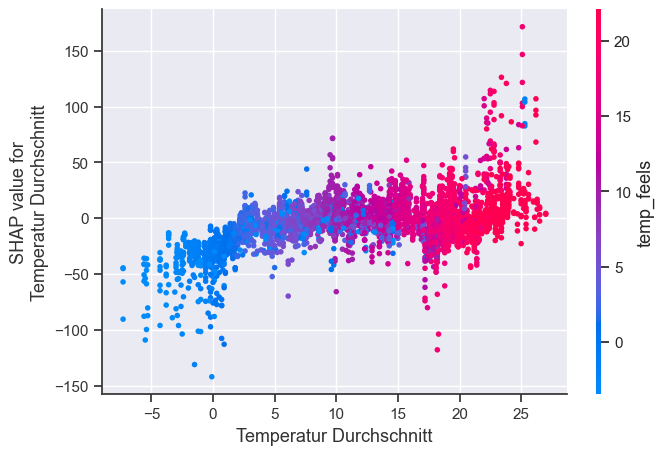

In [21]:
shap.dependence_plot("Temperatur Durchschnitt", shap_values, X_test)


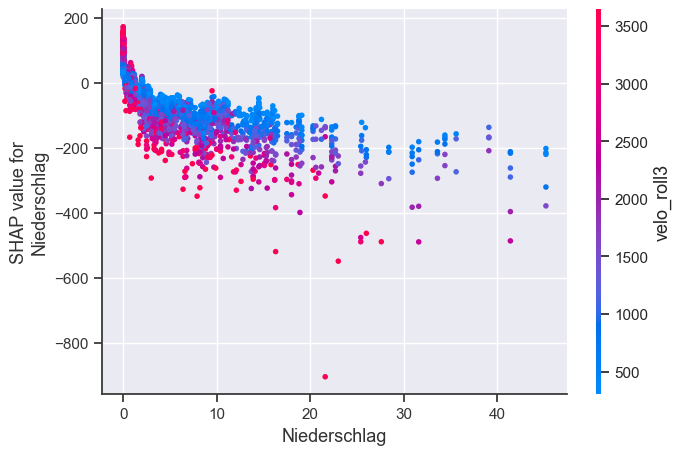

In [22]:
shap.dependence_plot("Niederschlag", shap_values, X_test)


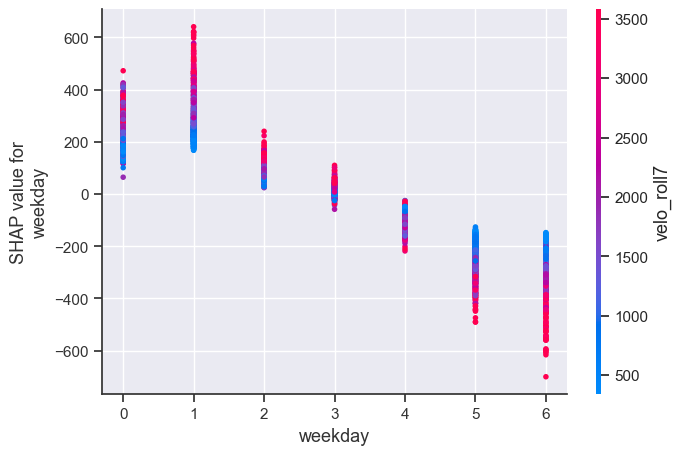

In [23]:
shap.dependence_plot("weekday", shap_values, X_test)


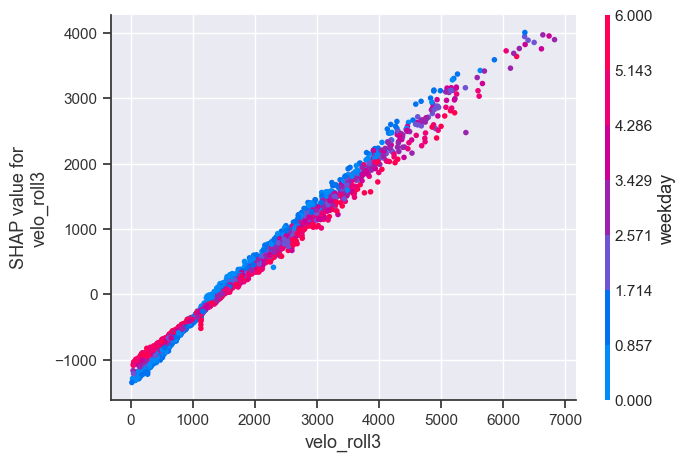

In [24]:
shap.dependence_plot("velo_roll3", shap_values, X_test)


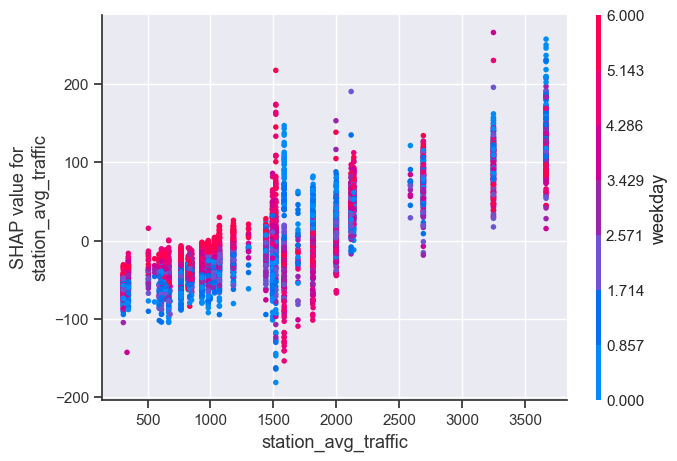

In [25]:
shap.dependence_plot("station_avg_traffic", shap_values, X_test)


Analyse:
Die SHAP-Dependence-Plots zeigen, dass das Modell hochgradig nichtlineare und interaktive Zusammenhänge gelernt hat.
Temperatur wirkt positiv, jedoch erst ab ca. 10°C stark. Niederschlag reduziert die Nachfrage deutlich, wobei der Effekt bereits bei geringen Mengen sichtbar ist.
Der Wochentag hat eine sehr klare Struktur: Dienstag ist der stärkste Verkehrstag, während Sonntag der schwächste ist.
Der 3-Tage-Rolling-Durchschnitt ist der stärkste Prädiktor im Modell: Hohe Rolling-Werte der letzten Tage führen fast deterministisch zu hohen Vorhersagen.

# SHAP interaction values

In [27]:
shap_inter = explainer.shap_interaction_values(X_test)


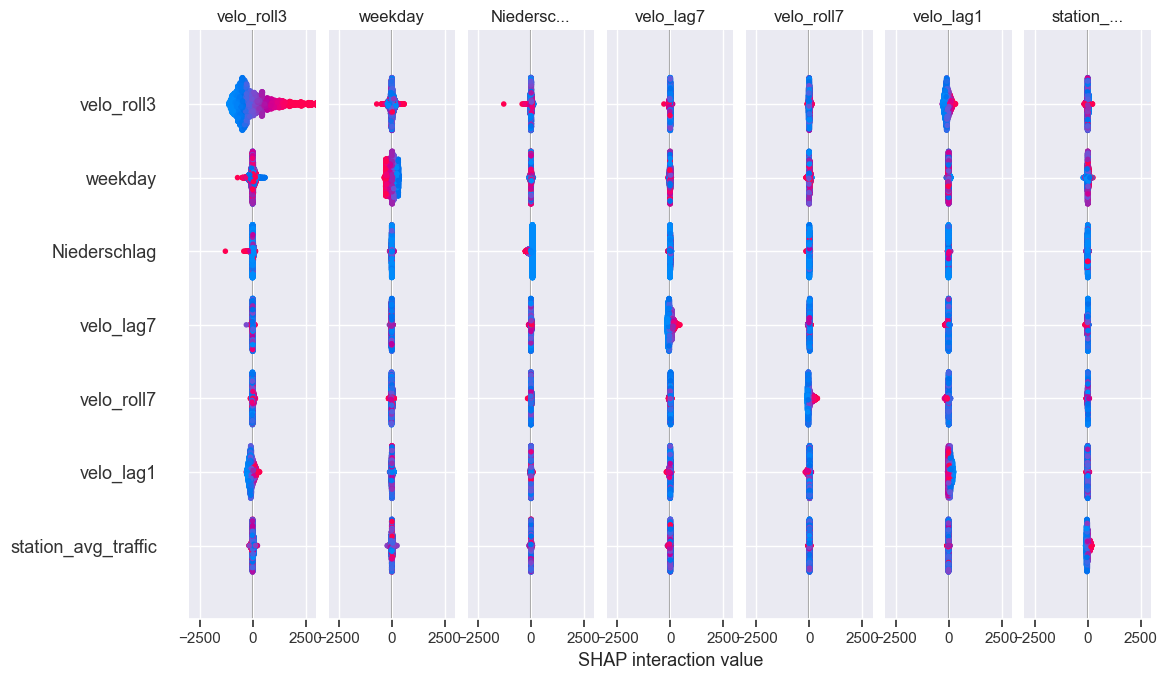

In [28]:
shap.summary_plot(shap_inter, X_test)

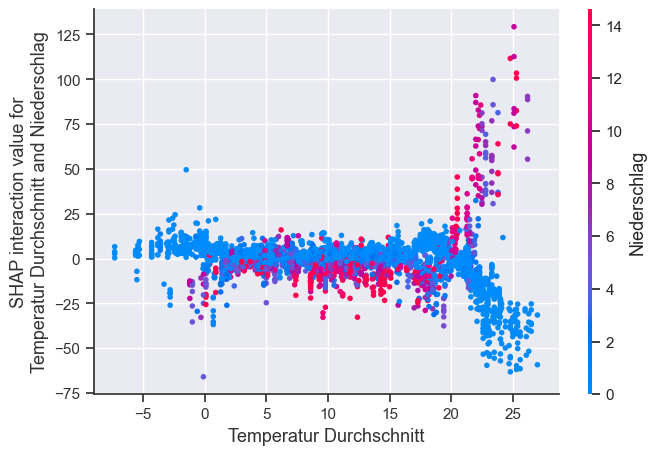

In [29]:
shap.dependence_plot(
    ("Temperatur Durchschnitt", "Niederschlag"),
    shap_inter,
    X_test
)


interpretation
<10C
Bei kalten Temperaturen ist der Temperatureffekt kaum abhängig vom Regen.
Es ist ohnehin kalt – Regen macht es nicht „viel schlimmer
10-20C
In moderaten Temperaturen verstärkt Regen den negativen Effekt leicht, aber nicht dramatisch.
Hier sind klassische Übergangsmonate: Frühling (April, Mai)
Herbst (Oktober)
Regen dämpft, aber nicht extrem.
>20
Im Sommer verstärkt Regen den Temperatureffekt – aber NICHT im Sinne von “besser”, sondern “anders”. → starke Interaktionen: Wärme verstärkt eigentlich das Fahren,
aber Regen bricht das Muster → große Unregelmäßigkeit
Das Modell erkennt damit, dass Regen an warmen Tagen ein „ungewöhnliches“ Mobilitätsverhalten erzeugt, das nicht durch lineare Additionen erklärbar ist.

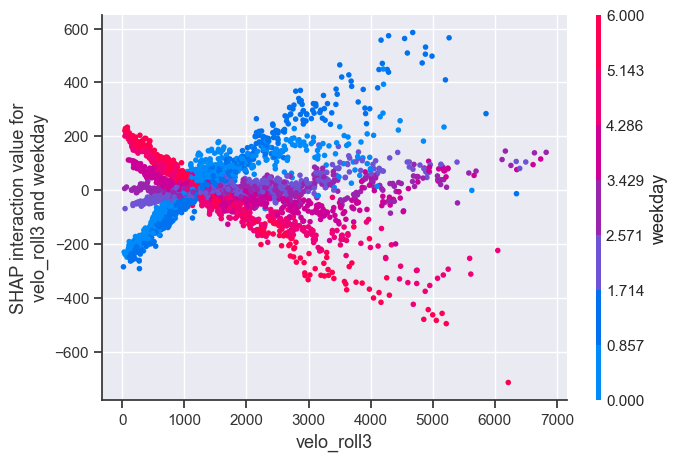

In [30]:
shap.dependence_plot(("velo_roll3", "weekday"), shap_inter, X_test)


Die Interaktion zwischen velo_roll3 und dem Wochentag zeigt, dass Verkehrstrends stark vom Wochentag abhängig sind. Hohe Rolling-Werte führen an Arbeitstagen zu einer deutlichen Verstärkung des positiven Effekts, während derselbe Trend an Wochenenden abgeschwächt wird. Dies spiegelt die klare Pendlerlogik wider.

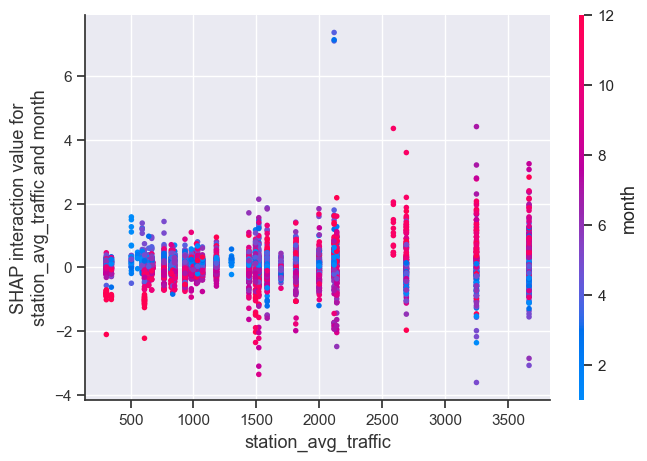

In [31]:
shap.dependence_plot(("station_avg_traffic", "month"), shap_inter, X_test)


Die Interaktionswerte zwischen station_avg_traffic und dem Monat sind sehr gering, was darauf hinweist, dass saisonale Schwankungen das relative Verkehrsaufkommen an den verschiedenen Stationen kaum verändern. Hauptstationen bleiben ganzjährig stärker frequentiert als Nebenstationen.

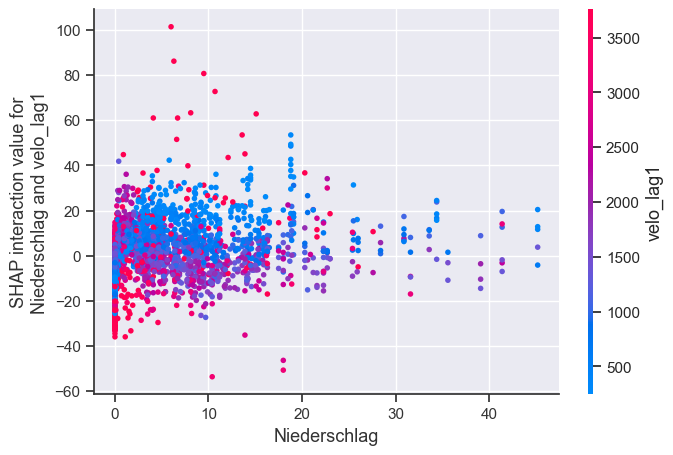

In [32]:
shap.dependence_plot(("Niederschlag", "velo_lag1"), shap_inter, X_test)


In [33]:
explainer = shap.TreeExplainer(xgb)
shap_inter = explainer.shap_interaction_values(X_test)

In [35]:
# absolute Mittelwerte der Interaktionen über alle Samples
mean_inter = np.abs(shap_inter).mean(axis=0)

# DataFrame
interaction_df = pd.DataFrame(
    mean_inter,
    index=X_test.columns,
    columns=X_test.columns
)

interaction_df

,day_of_year,Niederschlag,Temperatur Durchschnitt,weekday,weekend,is_holiday,month,sin_day,cos_day,temp_feels,temp_sq,is_rain,heavy_rain,velo_roll3,velo_roll7,velo_lag1,velo_lag7,station_avg_traffic,location_cluster
day_of_year,5.962877,2.287425,2.266157,2.168338,0.459430,1.486911,0.068663,2.006964,0.969746,2.445985,0.732371,0.302982,0.074350,3.098258,1.127449,1.778131,1.262478,1.209118,0.251331
Niederschlag,2.287427,77.190727,3.497927,4.760060,0.748756,1.814751,0.260254,2.498516,3.794842,2.267179,1.300064,0.000000,0.000000,11.323196,3.989760,3.551641,5.063519,3.304570,0.686840
Temperatur Durchschnitt,2.266156,3.497928,10.062324,2.137271,0.312017,1.357287,0.351210,2.293350,2.166029,3.184045,0.972659,0.394358,0.187243,3.327021,1.436512,1.803730,1.607093,2.872854,0.246597
weekday,2.168337,4.760061,2.137267,178.466537,0.000000,3.451995,0.380026,3.091724,1.628345,3.702068,0.685097,0.895789,0.691997,34.868973,10.644742,7.814137,6.155968,12.278902,2.508099
weekend,0.459430,0.748756,0.312017,0.000000,25.831974,0.579640,0.015432,0.872661,0.313071,1.227890,0.098267,0.244740,0.177231,5.030189,1.544873,1.349188,1.611922,2.497113,0.262539
is_holiday,1.486910,1.814750,1.357287,3.451994,0.579640,25.259222,0.246020,4.845521,1.445374,2.673667,0.552885,0.336023,0.064630,2.084231,1.038517,1.493060,3.184790,2.480422,0.127075
month,0.068663,0.260253,0.351210,0.380026,0.015432,0.246021,0.941373,0.251432,0.193005,0.325532,0.098788,0.034272,0.010011,0.536221,0.158308,0.287846,0.190025,0.157168,0.031145
sin_day,2.006964,2.498516,2.293350,3.091720,0.872661,4.845520,0.251432,9.713567,0.996514,2.629511,1.304896,0.215035,0.109898,2.489375,0.971476,1.180473,1.603976,1.137626,0.207582
cos_day,0.969746,3.794839,2.166029,1.628346,0.313071,1.445374,0.193005,0.996514,8.113623,1.965414,0.789241,0.383747,0.104749,2.139206,0.990509,1.310784,1.557285,1.819556,0.194985
temp_feels,2.445986,2.267177,3.184046,3.702073,1.227890,2.673669,0.325532,2.629512,1.965415,29.832615,0.834559,0.432047,0.286907,5.481100,2.028126,2.163372,3.074000,3.844730,0.417761


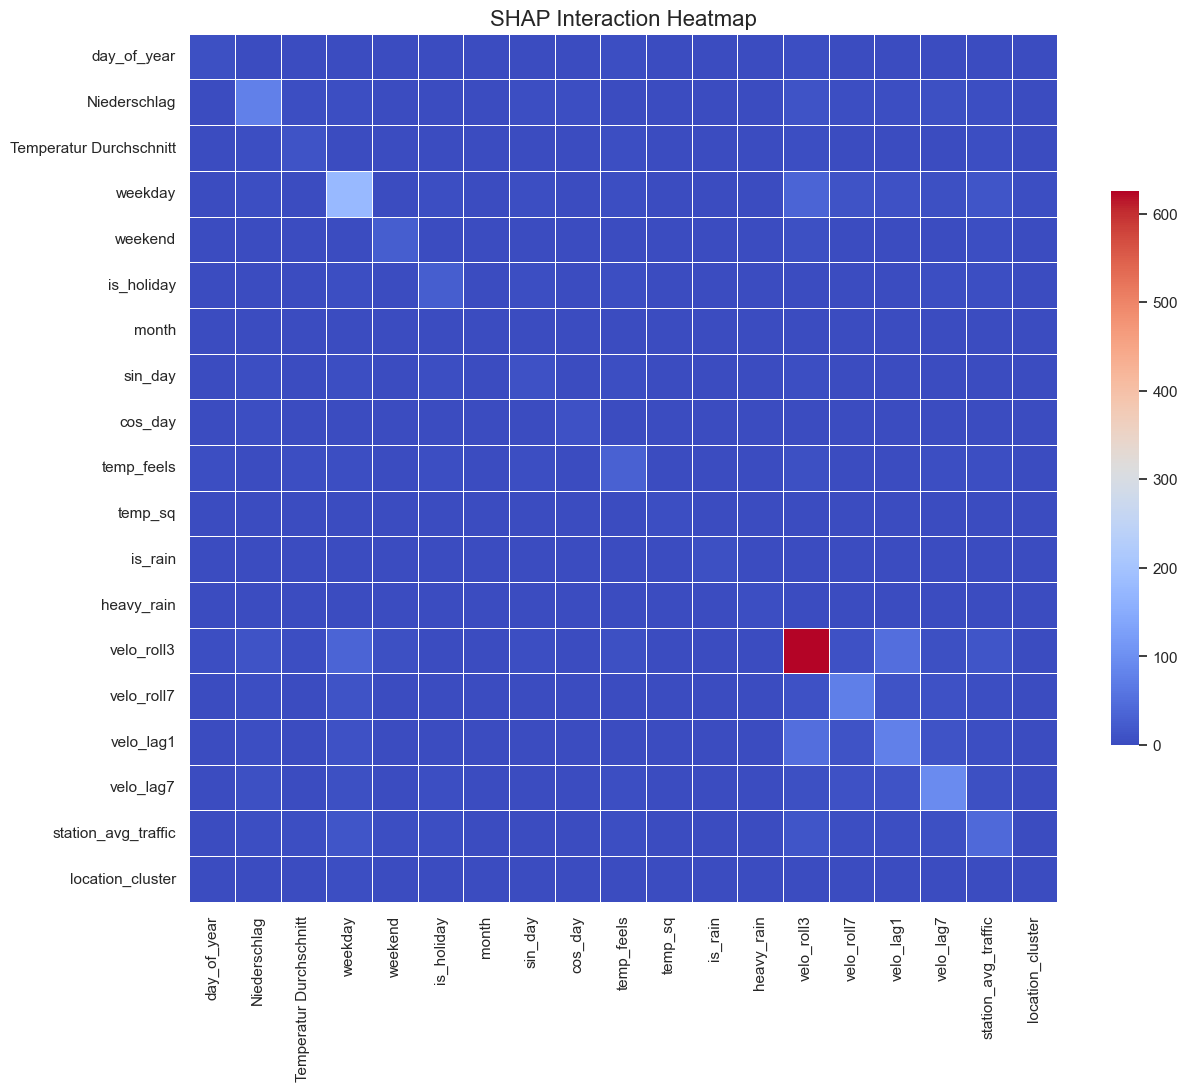

In [36]:
plt.figure(figsize=(14, 12))
sns.heatmap(
    interaction_df,
    cmap="coolwarm",
    annot=False,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.6}
)
plt.title("SHAP Interaction Heatmap", fontsize=16)
plt.show()


C:\Users\ekoutsoc\AppData\Local\Temp\ipykernel_12856\4163050558.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rmse_cluster = temp.groupby("location_cluster").apply(


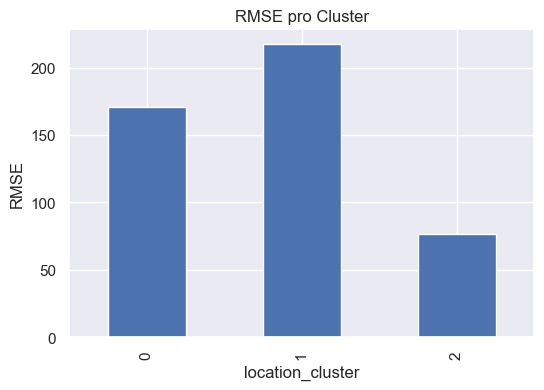

In [39]:
rmse_cluster = temp.groupby("location_cluster").apply(
    lambda x: np.sqrt(mean_squared_error(x["true"], x["pred"]))
)

rmse_cluster.plot(kind="bar", figsize=(6,4), title="RMSE pro Cluster")
plt.ylabel("RMSE")
plt.show()



C:\Users\ekoutsoc\AppData\Local\Temp\ipykernel_12856\1941437382.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rmse_month = temp.groupby("month").apply(


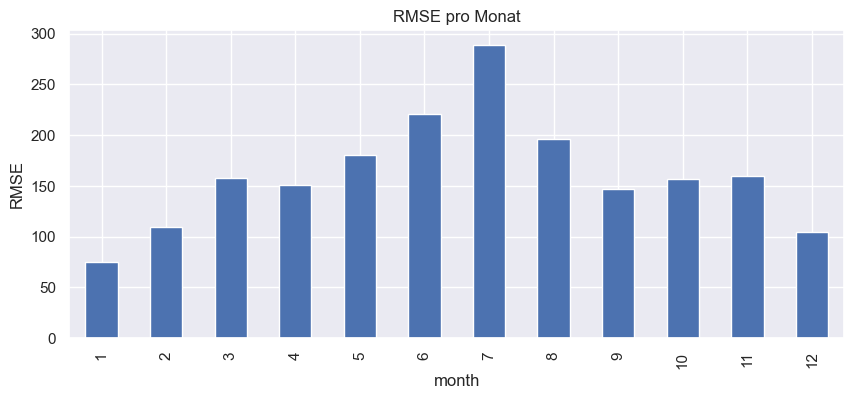

In [40]:
rmse_month = temp.groupby("month").apply(
    lambda x: np.sqrt(mean_squared_error(x["true"], x["pred"]))
)

rmse_month.plot(kind="bar", figsize=(10,4), title="RMSE pro Monat")
plt.ylabel("RMSE")
plt.show()
